# Practicing convolutions

In this notebook you will practice applying 2D, 2.5D and 3D convolutions to a medical volume using PyTorch. Conveniently, PyTorch offers the functionality of computing convolutions with arbitrary kernel sizes, and handles all the mechanics of striding and padding

In [1]:
import pydicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.ma as ma
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from PIL import Image
import math

plt.rcParams["figure.figsize"] = (7,7)

## Applying convolutional filters

In this section we will give you some starter code on how to apply 2D convolution using PyTorch

In [2]:
# Define a 4x4 edge filter kernel

conv_kernel = np.ones((4,4))
conv_kernel[2:,:] = -1
print(conv_kernel)

[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]]


In [3]:
# We will use Torch's convolutional layer for our convolutional filter operation

conv2d = nn.Conv2d(
    1, # Input size == 1 (we are dealing with 1 input channel)
    1, # Output size - we want to get 1 channel as an output
    kernel_size = (4, 4), # size of our filter kernel
    bias = False) # We do not need a bias for this operation
conv2d

Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)

In [4]:
# Let's turn our convolutional kernel into a tensor which we can use to initialize our convolutional layer

params = torch.from_numpy(conv_kernel).type(torch.FloatTensor).unsqueeze(0).unsqueeze(0)

# Note the unsqeeze operation - this is effectively adding empty dimensions to the vector bringing it to 4 dimensions
# Torch expects parameter vector of size (output_channels, input_channels, kernel x dimension, kernel y dimension)

conv2d.weight = torch.nn.Parameter(params)

In [5]:
params.shape

torch.Size([1, 1, 4, 4])

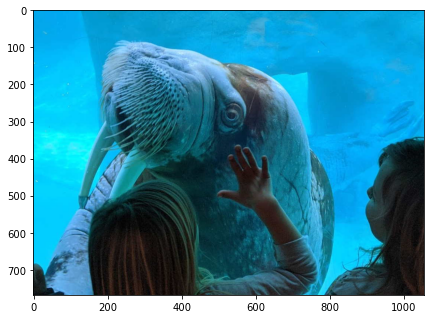

In [6]:
# Let's load an image of the adorable walrus:

walrus = Image.open('data/walrus.jpg')
plt.imshow(walrus)

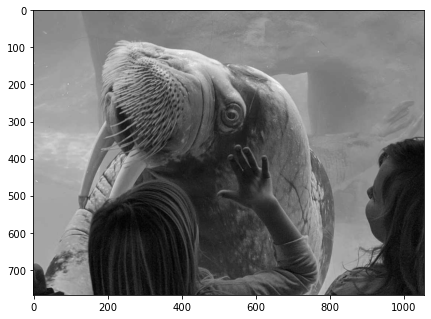

In [7]:
# Now let's convert it to grayscale and normalize (because this is what our convolution operation is expecting)

walrus = walrus.convert("L")
walrus = np.array(walrus)
walrus = walrus.astype(np.single)/0xff

plt.imshow(walrus, cmap="gray")

In [8]:
# Conv2D layer is expecting a 4D tensor (batch_size, channels, width, height)
# Let's bring the walrus into proper shape. We have batch of size one and only one channel
# so we will use the unsqueeze operation for this

walrus_tensor = torch.from_numpy(walrus).unsqueeze(0).unsqueeze(1)
walrus_tensor.shape

torch.Size([1, 1, 768, 1054])

In [9]:
%%time
# Let's compute the convolution map and ReLU activations. Note that we also used the time "magic function"
# to see how long it takes. Later on, you will compare other convolution methods that you will try.

convolved = conv2d(walrus_tensor)
relu = F.relu(convolved)

CPU times: user 43 ms, sys: 7.89 ms, total: 50.9 ms
Wall time: 62.8 ms


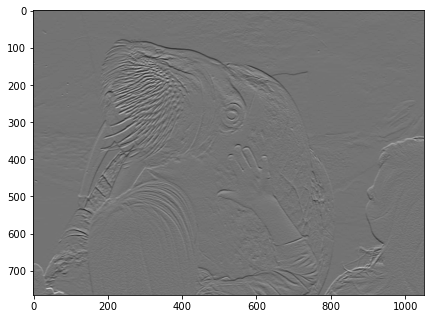

In [10]:
# And let's visualize them!

plt.imshow(np.squeeze(convolved.detach().numpy()), cmap="gray")

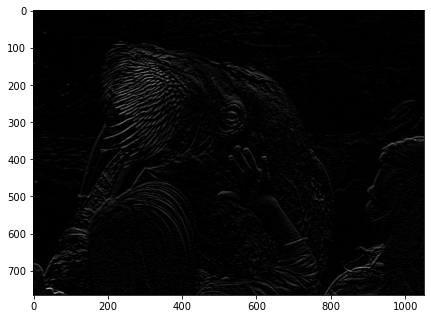

In [11]:
plt.imshow(np.squeeze(relu.detach().numpy()), cmap="gray")

Hurray, we've run a 2D convolutional layer with custom kernel, using PyTorch. Onwards to medical applications!

## Loading a NIFTI volume

Remember how to use NiBabel to load those NIFTI volumes? Here's a refresher

In [12]:
# Let's load our image

nii_img = nib.load("data/spleen.nii.gz")
img = nii_img.get_fdata()

In [13]:
img.shape

(512, 512, 41)

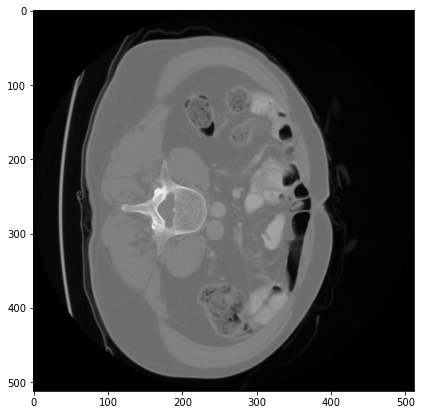

In [14]:
# Let's visualize a slice:

plt.imshow(img[:,:,0], cmap="gray")

By now you should've seen enough of these to recognize that you are looking at an abdominal cross-section. Now you are ready to apply convolutions!

But before we go there - a couple of notes about pixel sizes, on this particular image.

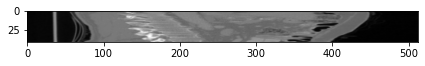

In [15]:
# Let's visualize sagittal cross-section at cut 250 (we will use rot90 since we want to orient the image it properly)

plt.imshow(np.rot90(img[250,:,:]), cmap = "gray")

Wow, that looks squished!

Remember our conversations about anisotropic voxels ? As you might have guessed, our pixels are much shorter in z dimension than they are in x and y. Let's see what we can do about it.

In [16]:
nii_img.header["pixdim"]

array([1.      , 0.744141, 0.744141, 5.      , 0.      , 0.      ,
       0.      , 0.      ], dtype=float32)

Remember how we scaled DICOM image in previous lesson, to account for difference between in-plane resolution and resolution across z-axis? In NIFTI one extracts proper voxel aspect ratio from NIFTI image using the pixdim field.

Unlike DICOM, NIFTI files store all their pixel dimensions in a single place - pixdim field. Also unlike DICOM this field also stores a bunch of other stuff related to uses of NIFTI format beyond static 3D images. If you're curious what those are - check out the [NIFTI documentation](https://nifti.nimh.nih.gov/nifti-1/documentation/nifti1fields/nifti1fields_pages/pixdim.html/document_view). 

For the purpose of this exercise we are interested in values at locations 1, 2 and 3 - these are our x, y and z dimensions respectively.

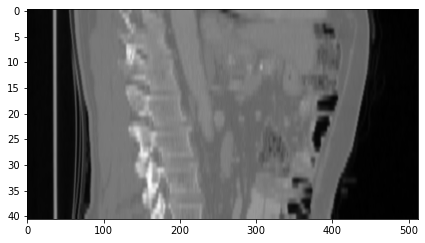

In [17]:
img2d = np.rot90(img[250,:,:])
plt.imshow(img2d, cmap = "gray", aspect=nii_img.header["pixdim"][3]/nii_img.header["pixdim"][1])

In [18]:
# We will also give you a convenience function to visualize all slices in a grid as thumbnails:

def display_volume_slices(img, w, h):
    plot_w = w
    plot_h = h

    # You can play with figsize parameter to adjust how large the images are
    fig, ax = plt.subplots(plot_h, plot_w, figsize=[35,35])

    for i in range(plot_w*plot_h):
        plt_x = i % plot_w
        plt_y = i // plot_w
        if (i < len(img)):
            ax[plt_y, plt_x].set_title(f"slice {i}")
            ax[plt_y, plt_x].imshow(img[i], cmap='gray')
        ax[plt_y, plt_x].axis("off")

    plt.show()

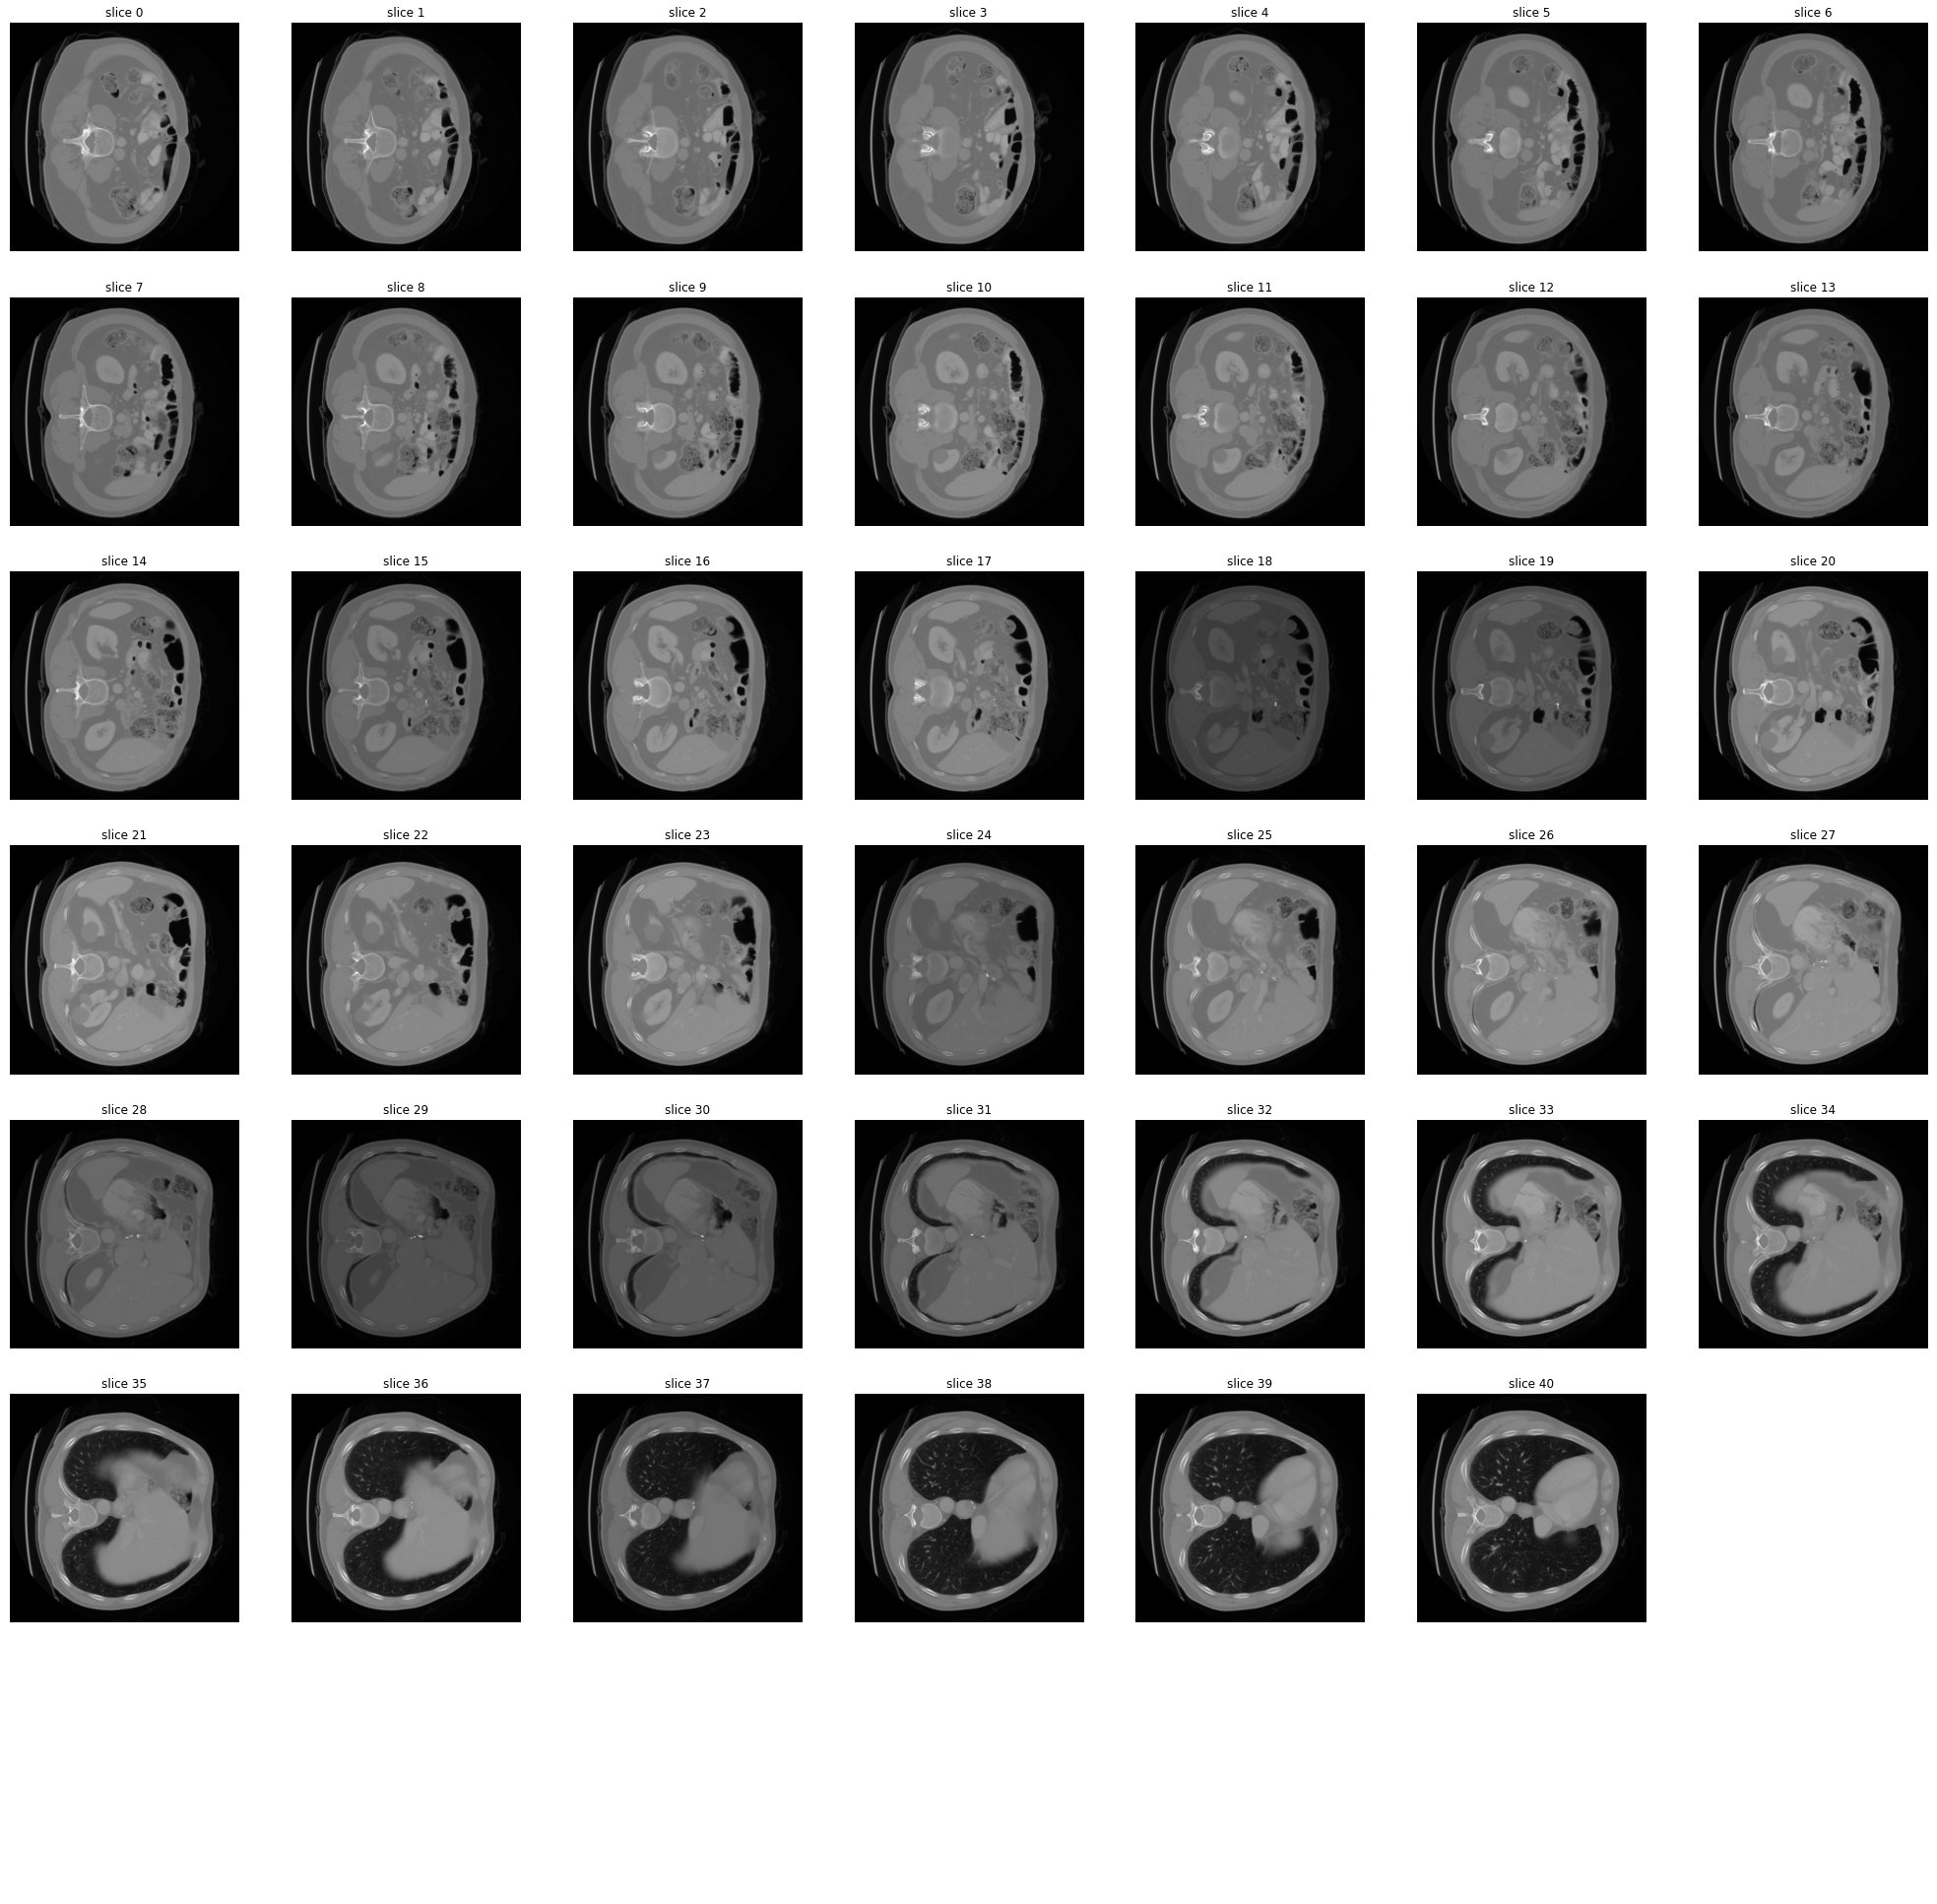

In [19]:
# And let's visualize ALL slices
#
# Note that we are calling np.transpose here because our display_volume_slices iterates over 0th dimension
# of the input volume. Our Nibabel volumes have z dimension stored in the 2nd position, so we 
# move the z-dimension in front of the other two here

display_volume_slices(np.transpose(img, (2, 0, 1)), 7, 7)

---

## 2D Convolutions

**TASK**: Using the kernel we have defined above (or any other kernel you like), use the "2D Convolution" method to create a volume of convolution maps for all of the slices in our volume. Visualize them.

Use %%time (as we've done above) to see how much time it takes.  
How many parameters does define the convolution operation?

----

# 3D Convolutions

**TASK**: Using a 3D version of the same kernel, compute and time full 3D convolutions by using PyTorch's Conv3D layer. Note that our kernel represents a 2D edge filter. What would be a 3D edge filter?

----
# 2.5D Convolutions

> **Extra credit exercise**: _Depending on how familiar you are with Numpy and PyTorch, this exercise may take up to a few hours to complete. This exercise may help you understand the architecture of convolutions better, but is not essential to understanding the course. If you feel like this would be too time consuming you are welcome to move on or take a peek at the solution._

Now Let's try 2.5D convolutions. That's a bit more difficult since we want to be specific about how exactly we select data for our extra planes, and also for it to be meaningful we would like to combine data in small areas around area of interest which means we would need to process image in patches. This is not something PyTorch offers right out of the box, and you would engage in something like this if you are conscious of performance, so you would want to have control over this anyway. A bit more coding will be required than previous exercises. 

We will try to recreate the approach to building convolutions which has been presented in [this paper from the NIH](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4295635/). Specifically, we will build a layer that runs a convolutional filter over patches that look like this:

<img src="convolutions.img/25d.jpg" width="200">

**TASK**: Using same kernel, compute and time creation of a volume of convolutional feature maps using the 2.5D convolutions approach by looking at 16x16x16 patches and extracting three square segments from the center of the patch, along the cardinal planes, similar to how it was described in the lesson video. Treat the three 16x16 segments as input channels for your convolutional layer still using one output channel). Visualize all axial slices of your convolutional feature map.

